# Predicting Final Season NBA Awards Using Player Data
### Evan S, Joey G, Ryan S, Jack V

## Introduction
In the NBA, individual awards are presented annually to the highest performing players in the league. These awards represent a player's excellence in some aspect of basketball, which could be how amazing they are on defense, how clutch they are when the lights are brightest, or how impactful they are coming off the bench. They are decided through a voting system where a select panel of sports journalists and broadcasters vote on who should win each award. These awards are valuable points in any player's argument to be entered into the Hall of Fame, influencing how their careers will be remembered for decades, even centuries, into the future.

In this analysis, we will create prediction models for four major individual awards: Most Valuable Player (MVP), Defensive Player of the Year (DPOY), Rookie of the Year (ROTY), and All-NBA Team. And with these models, we will investigate what statistics are most indicative of a player's likelihood to win an award, as well as make predictions for the 2025 winners.

The data we will be working on is a comprehensive dataset of NBA player, game, and season statistics from 1947-present. The dataset originates from kaggle, which was scraped from basketball-reference.com. Advanced statistics were not calculated until 1980, so we will filter for data between the years 1980 and 2024.

Link: https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats?select=Advanced.csv

Note: The data was imported on April 10, 2025 (before the end of the 24-25 season). 

In [ ]:
# Import data & clean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import tree, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from matplotlib.ticker import PercentFormatter
# load in data
end_of_season_teams = pd.read_csv('nba_data/End of Season Teams (Voting).csv')
player_awards = pd.read_csv('nba_data/Player Award Shares.csv')
player_career = pd.read_csv('nba_data/Player Career Info.csv')
player_season = pd.read_csv('nba_data/Player Season Info.csv')
player_shooting = pd.read_csv('nba_data/Player Shooting.csv')
player_totals = pd.read_csv('nba_data/Player Totals.csv')
team_summary = pd.read_csv('nba_data/Team Summaries.csv')
player_per_game = pd.read_csv('nba_data/Player Per Game.csv')

In [2]:
# cleaning end_of_season_teams
all_nba_players = end_of_season_teams[
                        (end_of_season_teams['type'] == 'All-NBA')][
                            ['player', 'season', 'number_tm', 'pts_won']]

all_nba_players.rename(columns={'number_tm': 'all_nba_team', 
                             'pts_won' : 'all_nba_voting_pts'}, inplace=True)
#all_nba_players.head()


# cleaning player_awards into 3 different dfs
dpoy_players = player_awards[(player_awards['award'] == 'dpoy')][
                            ['player', 'season', 'tm', 'pts_won', 'winner']]

dpoy_players.rename(columns={'pts_won' : 'dpoy_voting_pts', 
                             'winner':'won_dpoy',
                             'tm' : 'team'}, inplace=True)

mvp_players = player_awards[(player_awards['award'] == 'nba mvp')][
                            ['player', 'season', 'tm', 'pts_won', 'winner']]

mvp_players.rename(columns={'pts_won' : 'mvp_voting_pts', 
                             'winner':'won_mvp',
                             'tm' : 'team'}, inplace=True)


roty_players = player_awards[(player_awards['award'] == 'nba roy')][
                            ['player', 'season', 'tm', 'pts_won', 'share', 'winner']]

roty_players.rename(columns={'pts_won': 'roty_voting_pts',
                             'share' : 'roty_share', 
                             'winner':'won_roty',
                             'tm' : 'team'}, inplace=True)


# cleaning player_career
player_career = player_career[['player', 'num_seasons']]
#player_career.head(10)


# cleaning player_season
player_season = player_season[['player', 'season', 'seas_id', 'pos', 'age', 'tm', 'experience']]
player_season['team_count'] = (
    player_season
    .groupby(['player', 'season'])['tm'] 
    .transform('nunique') # adds a  column with number of teams
    # so we can remove all people on more than 1 team in a season
)

player_season = player_season.query("team_count == 1")

player_season.rename(columns={'tm': 'abbreviation'}, inplace=True)
#player_season.head(10)

# cleaning player_shooting
player_shooting['team_count'] = (
    player_shooting
    .groupby(['player', 'season'])['tm'] 
    .transform('nunique') # adds a  column with number of teams
    # so we can remove all people on more than 1 team in a season
)


# selects only players with 1 team in a season
# an NBA MVP, 1st Team Member, and ROTY have never won the award
# while playing for 2 teams in the year they won
# There has been 1 NBA DPOY that was on 2 teams the year, he won the award
# That player is Dikembe Motumbo and we will still be removing him for consistency
player_shooting = player_shooting.query("team_count == 1")[['player', 'season', 'seas_id', 'avg_dist_fga',
       'fg_percent_from_x2p_range', 'fg_percent_from_x3p_range',
       'percent_assisted_x2p_fg', 'percent_assisted_x3p_fg', 'corner_3_point_percent']]
#player_shooting.head(10)


# cleaning player_shooting
player_totals['team_count'] = (
    player_totals
    .groupby(['player', 'season'])['tm'] 
    .transform('nunique') # adds a  column with number of teams
    # so we can remove all people on more than 1 team in a season
)

# selects only players with 1 team in a season
# an NBA MVP, 1st Team Member, and ROTY have never won the award
# while playing for 2 teams in the year they won
# There has been 1 NBA DPOY that was on 2 teams the year, he won the award
# That player is Dikembe Motumbo and we will still be removing him for consistency
player_totals = player_totals.query("team_count == 1")[['player', 'season', 'seas_id', 'g', 'gs', 'mp', 'fg', 'fga', 
                                                        'fg_percent', 'x3p', 'x3pa', 'x2p', 'x2pa', 
                                                        'e_fg_percent', 'ft', 'fta', 'ft_percent', 'orb', 
                                                        'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pts']]


# cleaning team_summary
team_summary = team_summary[['season', 'team', 'abbreviation', 'playoffs', 'w', 'l', 'o_rtg', 'd_rtg', 'n_rtg', 'pace']]
#team_summary.head()

# cleaning player_per_game
player_per_game['team_count'] = (
    player_per_game
    .groupby(['player', 'season'])['tm']
    .transform('nunique')
)

player_per_game = player_per_game.query("team_count == 1")[['player', 'season', 'mp_per_game', 'trb_per_game', 
                                                            'ast_per_game', 'stl_per_game', 'blk_per_game', 'pts_per_game']]


In [3]:
# combining into one df
# player_season -> player_shooting -> player_totals --> player_career --> team summary 
# then add awards df individually
nba = (
    player_season
    .merge(player_shooting, on = ['player', 'season'], how = 'left')
    .merge(player_totals, on = ['player', 'season'], how = 'left')
    .merge(player_career, on = ['player'], how = 'left')
    .merge(team_summary, on = ['abbreviation', 'season'], how = 'left')
    .merge(player_per_game, on = ['player', 'season'], how = 'left')
).query("season >= 1980").rename(
           columns = {
                'pos': 'position', 
                'abbreviation' : 'team_abbr',
                'fg_percent_from_x2p_range' : 'fg_percent_2p', 
                'fg_percent_from_x3p_range' : 'fg_percent_3p', 
                'g' : 'games_played', 
                'gs' : 'games_started', 
                'mp' : 'minutes_played',
                'orb' : 'off_reb', 
                'drb' : 'def_reb', 
                'trb' : 'tot_reb',
                'num_seasons' : 'total_seasons_played',
                'playoffs' : 'team_made_playoffs',
                'w' : 'team_wins',
                'l' : 'team_losses',
                'o_rtg' : 'team_off_rtg',
                'd_rtg' : 'team_def_rtg',
                'n_rtg' : 'team_net_rtg',
                'pace' : 'team_pace'               
           })

# selecting and ordering columns
nba = nba[['seas_id','player', 'season', 'team', 'team_abbr', 'position', 'age',
               'experience', 'avg_dist_fga', 'fg_percent_2p', 'fg_percent_3p',
               'percent_assisted_x2p_fg', 'percent_assisted_x3p_fg',
               'corner_3_point_percent', 'games_played', 'games_started',
               'minutes_played', 'fg', 'fga', 'fg_percent', 'x3p', 'x3pa', 'x2p',
               'x2pa', 'e_fg_percent', 'ft', 'fta', 'ft_percent', 'off_reb', 'def_reb', 'tot_reb',
               'ast', 'stl', 'blk', 'tov', 'pts', 'mp_per_game', 'trb_per_game', 'ast_per_game', 
               'stl_per_game', 'blk_per_game', 'pts_per_game', 'total_seasons_played',
               'team_made_playoffs', 'team_wins', 'team_losses', 'team_off_rtg',
               'team_def_rtg', 'team_net_rtg', 'team_pace']]


nba.head(10)

,seas_id,player,season,team,team_abbr,position,age,experience,avg_dist_fga,fg_percent_2p,...,blk_per_game,pts_per_game,total_seasons_played,team_made_playoffs,team_wins,team_losses,team_off_rtg,team_def_rtg,team_net_rtg,team_pace
5747,7991.0,Abdul Jeelani,1980,Portland Trail Blazers,POR,SF,25.0,1,NaN,NaN,...,0.5,9.6,2,True,38.0,44.0,103.4,104.3,-0.9,98.6
5748,7992.0,Adrian Dantley,1980,Utah Jazz,UTA,SF,24.0,4,NaN,NaN,...,0.2,28.0,15,False,24.0,58.0,104.2,110.4,-6.2,97.6
5749,7993.0,Al Skinner,1980,Philadelphia 76ers,PHI,SG,27.0,6,NaN,NaN,...,0.0,1.0,6,True,59.0,23.0,105.0,101.0,4.0,103.0
5750,7997.0,Allan Bristow,1980,Utah Jazz,UTA,SF,28.0,7,NaN,NaN,...,0.1,11.6,10,False,24.0,58.0,104.2,110.4,-6.2,97.6
5751,7998.0,Allen Leavell,1980,Houston Rockets,HOU,PG,22.0,1,NaN,NaN,...,0.4,10.9,10,True,41.0,41.0,108.1,108.0,0.1,101.2
5752,7999.0,Alonzo Bradley,1980,Houston Rockets,HOU,SF,26.0,3,NaN,NaN,...,0.0,1.9,3,True,41.0,41.0,108.1,108.0,0.1,101.2
5753,8000.0,Alvan Adams,1980,Phoenix Suns,PHO,C,25.0,5,NaN,NaN,...,0.7,14.9,13,True,55.0,27.0,105.6,102.2,3.4,104.8
5754,8001.0,Alvin Scott,1980,Phoenix Suns,PHO,SF,24.0,3,NaN,NaN,...,0.7,4.4,8,True,55.0,27.0,105.6,102.2,3.4,104.8
5755,8002.0,Andre Wakefield,1980,Utah Jazz,UTA,SG,25.0,2,NaN,NaN,...,0.0,1.9,2,False,24.0,58.0,104.2,110.4,-6.2,97.6
5756,8003.0,Anthony Roberts,1980,Denver Nuggets,DEN,SF,24.0,3,NaN,NaN,...,0.1,7.7,5,False,30.0,52.0,103.4,107.6,-4.2,103.9


In [4]:
# Create dataframe of ROTY candidates
roty = (
    nba.query("experience == 1 & games_played >= 40") # only keeping players with 1 season of experience and min. 40 games played to train the model better
    .merge(roty_players, on = ['player', 'season'], how = 'left')
    .reset_index(drop=True)
)
roty['roty_share'] = roty['roty_share'].fillna(0)
roty['won_roty'] = roty['won_roty'].fillna(False)
roty.drop_duplicates(subset=['seas_id'], inplace=True)
# Remove rows with missing values in variables of interest
# roty.dropna(subset = ['mp_per_game', 'fg_percent', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'pts_per_game'], inplace = True)

C:\Users\Evan\AppData\Local\Temp\ipykernel_25852\1365635473.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  roty['won_roty'] = roty['won_roty'].fillna(False)


## Data Summary
This dataset consolidates comprehensive season-level player and team data from various sources for the NBA, starting from the 1980 season. It merges information from six key data files: Player Season Info, Player Shooting, Player Per Game, Player Totals, Player Career Info, Team Summaries, Player Award Shares, End of Season Teams (Voting). 

To ensure consistency and relevance in award-related analysis, players who appeared for more than one team in a single season were removed. This decision aligns with historical patterns, as no MVP, All-NBA First Team member, or Rookie of the Year has ever won while playing for multiple teams in a season. Although one Defensive Player of the Year (Dikembe Mutombo) achieved this, he was still excluded for consistency.

Award data was separated into distinct datasets for MVP, DPOY, and ROTY honors. Each was attached seperately to the NBA data to make a dataframe specifically for that machine learning application.

Each row in the final nba DataFrame represents a single player’s season and includes a wide range of information. Player-related details include their name, age, position, years of experience, and total number of seasons played. Team information consists of the franchise name, win-loss record, and whether the team made the playoffs or not. Player performance stats include totals and percentages for field goals, three-pointers, two-pointers, free throws, rebounds, assists, steals, blocks, turnovers, and points scored. Shooting tendencies are also covered, with features like average distance of field goal attempts, percentage of assisted field goals, and corner three-point shooting accuracy.

## EDA
Below, we will examine some trends within the data before we build our models.

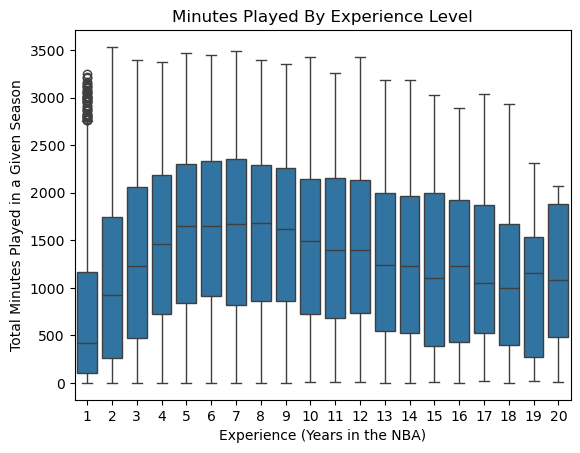

In [5]:
# EDA
# Player Experience
nba2 = nba.query("experience <= 20")
sns.boxplot(data=nba2, x='experience', y='minutes_played')
plt.xlabel('Experience (Years in the NBA)')
plt.ylabel('Total Minutes Played in a Given Season')
plt.title('Minutes Played By Experience Level')
plt.show();

The trend observed in the boxplots showing the number of minutes played by the number of seasons played in the NBA is significant to the project because it highlights how player experience and playing time are correlated, which could directly impact their chances of receiving an NBA award. Generally, players in their early seasons do not get as many minutes as veteran players. Players with more seasons played typically have more opportunities to accumulate minutes on the court, which could translate to more production and performance consistency. 
Examining this trend helps us understand the role of experience in player performance, which can inform the model predicting award outcomes by providing a foundation for factors like player development.

In [6]:
# Bar chart of MVPs, DPOYs, and ROTYs per team
roty_perteam = (roty_players.drop(columns = ['player', 'roty_share'])
                .groupby('team')
                .agg(roty_count = ('won_roty', 'count'))
                .sort_values('roty_count', ascending=False))
mvp_perteam = (mvp_players.drop(columns = ['player', 'mvp_voting_pts'])
               .groupby('team')
               .agg(mvp_count = ('won_mvp', 'count'))
               .sort_values('mvp_count', ascending=False))
dpoy_perteam = (dpoy_players.drop(columns = ['player', 'dpoy_voting_pts'])
                .groupby('team')
                .agg(dpoy_count = ('won_dpoy', 'count'))
                .sort_values('dpoy_count', ascending=False))

awards_perteam = (roty_perteam
                  .merge(mvp_perteam, on = 'team', how = 'left')
                  .merge(dpoy_perteam, on = 'team', how='left'))
awards_perteam['award_count'] = awards_perteam.sum(axis=1, numeric_only=True)
awards_perteam = awards_perteam.sort_values('award_count', ascending=False).reset_index()


The code above groups all NBA award winners by team and aggregates the number of awards won in each category and total awards won by the franchise. The graph below displays the top 13 teams with the most awards in their history.

In [7]:
# Bar chart of awards per team
fig_awardcount = px.bar(awards_perteam[0:13], 
                        x = 'team', 
                        y = ['roty_count', 'mvp_count', 'dpoy_count'], 
                        labels = {'team': 'Team', 'value' : 'Award Count'} , 
                        title = "Award Count per Team")
fig_awardcount.update_layout(legend_title_text = 'Award Name')
fig_awardcount.update_layout(legend_traceorder = 'reversed')
fig_awardcount.show()

The Boston Celtics have the most individual awards across all franchises with 122 awards. The Celtics also boast the most MVP awards with 81. The San Antonioo Spurs hold the most Defensive Player of the Year awards 42, and the Golden State Warriors hold the most Rookie of the Year awards with 16.

## Model Building & Implementation
Below, we will make a model predicting the following NBA awards: Most Valueable Player (MVP), Defensive Player of the Year (DPOY), Rookie of the Year (ROTY), and All-NBA Teams. In each subsection, we will explore the data used, make a model that is appropriate to the question we are asking, and test on the 2025 season assuming the model is reasonably good at predicting. 

### MVP

To begin, we create a dataset of MVP candidates who played at least 15 minutes per game. This is crucial because players with low playing time likely have minimal impact on the game outcomes or MVP voting. Their statistics might not be reliable or consistent across the season, and could introduce noise that skews results.

Then, we clean the data by filling in missing values with zerores.

In [8]:
mvp = (
    nba
    .merge(mvp_players, on = ['player', 'season'], how = 'left')
    #remove all players who averaged less than 15 mins per game.
    .query('minutes_played >= 15')
)

#Clean data
mvp['mvp_voting_pts'] = mvp['mvp_voting_pts'].fillna(0)
mvp['won_mvp'] = mvp['won_mvp'].fillna(False)

mvp.head(10)

C:\Users\Evan\AppData\Local\Temp\ipykernel_25852\2633845826.py:10: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,seas_id,player,season,team_x,team_abbr,position,age,experience,avg_dist_fga,fg_percent_2p,...,team_made_playoffs,team_wins,team_losses,team_off_rtg,team_def_rtg,team_net_rtg,team_pace,team_y,mvp_voting_pts,won_mvp
0,7991.0,Abdul Jeelani,1980,Portland Trail Blazers,POR,SF,25.0,1,NaN,NaN,...,True,38.0,44.0,103.4,104.3,-0.9,98.6,NaN,0.0,False
1,7992.0,Adrian Dantley,1980,Utah Jazz,UTA,SF,24.0,4,NaN,NaN,...,False,24.0,58.0,104.2,110.4,-6.2,97.6,NaN,0.0,False
3,7997.0,Allan Bristow,1980,Utah Jazz,UTA,SF,28.0,7,NaN,NaN,...,False,24.0,58.0,104.2,110.4,-6.2,97.6,NaN,0.0,False
4,7998.0,Allen Leavell,1980,Houston Rockets,HOU,PG,22.0,1,NaN,NaN,...,True,41.0,41.0,108.1,108.0,0.1,101.2,NaN,0.0,False
5,7999.0,Alonzo Bradley,1980,Houston Rockets,HOU,SF,26.0,3,NaN,NaN,...,True,41.0,41.0,108.1,108.0,0.1,101.2,NaN,0.0,False
6,8000.0,Alvan Adams,1980,Phoenix Suns,PHO,C,25.0,5,NaN,NaN,...,True,55.0,27.0,105.6,102.2,3.4,104.8,NaN,0.0,False
7,8001.0,Alvin Scott,1980,Phoenix Suns,PHO,SF,24.0,3,NaN,NaN,...,True,55.0,27.0,105.6,102.2,3.4,104.8,NaN,0.0,False
8,8002.0,Andre Wakefield,1980,Utah Jazz,UTA,SG,25.0,2,NaN,NaN,...,False,24.0,58.0,104.2,110.4,-6.2,97.6,NaN,0.0,False
9,8003.0,Anthony Roberts,1980,Denver Nuggets,DEN,SF,24.0,3,NaN,NaN,...,False,30.0,52.0,103.4,107.6,-4.2,103.9,NaN,0.0,False
10,8004.0,Armond Hill,1980,Atlanta Hawks,ATL,PG,26.0,4,NaN,NaN,...,True,50.0,32.0,105.2,102.3,2.9,98.9,NaN,0.0,False


Here are the 10 most recent MVP winners:

In [9]:
mvp.query("won_mvp == True").sort_values(by = 'season', ascending = False).head(10)

,seas_id,player,season,team_x,team_abbr,position,age,experience,avg_dist_fga,fg_percent_2p,...,team_made_playoffs,team_wins,team_losses,team_off_rtg,team_def_rtg,team_net_rtg,team_pace,team_y,mvp_voting_pts,won_mvp
17369,31672.0,Nikola Jokić,2024,Denver Nuggets,DEN,C,28.0,9,9.7,0.626,...,True,57.0,25.0,118.5,113.0,5.5,96.8,DEN,926.0,True
16735,30765.0,Joel Embiid,2023,Philadelphia 76ers,PHI,C,28.0,7,11.3,0.587,...,False,54.0,28.0,117.7,113.3,4.4,96.9,PHI,915.0,True
16382,30247.0,Nikola Jokić,2022,Denver Nuggets,DEN,C,26.0,7,10.2,0.652,...,True,48.0,34.0,114.5,112.1,2.4,97.8,DEN,875.0,True
15884,29456.0,Nikola Jokić,2021,Denver Nuggets,DEN,C,25.0,6,10.6,0.606,...,True,47.0,25.0,117.1,112.1,5.0,97.1,DEN,971.0,True
15230,28507.0,Giannis Antetokounmpo,2020,Milwaukee Bucks,MIL,PF,25.0,7,9.8,0.631,...,True,56.0,17.0,112.4,102.9,9.5,105.1,MIL,962.0,True
14781,27807.0,Giannis Antetokounmpo,2019,Milwaukee Bucks,MIL,PF,24.0,6,7.7,0.641,...,True,60.0,22.0,113.8,105.2,8.6,103.3,MIL,941.0,True
14329,27202.0,James Harden,2018,Houston Rockets,HOU,SG,28.0,9,15.3,0.531,...,True,65.0,17.0,114.7,106.1,8.6,97.6,HOU,965.0,True
14070,26813.0,Russell Westbrook,2017,Oklahoma City Thunder,OKC,PG,28.0,9,13.8,0.459,...,True,47.0,35.0,108.3,107.5,0.8,97.8,OKC,888.0,True
13657,26259.0,Stephen Curry,2016,Golden State Warriors,GSW,PG,27.0,7,17.4,0.566,...,True,73.0,9.0,114.5,103.8,10.7,99.3,GSW,1310.0,True
13233,25661.0,Stephen Curry,2015,Golden State Warriors,GSW,PG,26.0,6,17.1,0.528,...,True,67.0,15.0,111.6,101.4,10.2,98.3,GSW,1198.0,True


Next, we create the training dataset with predictors such as points and team wins trying to predict MVP voting points. Any missing values in the predictors are replaced with zerores.

In [10]:
#Dropping these columns as they're strings.
columns_to_drop =['season','player','team_x', 'team_y', 'team_made_playoffs','team_abbr','position','won_mvp']

X = mvp.drop(columns=columns_to_drop+['mvp_voting_pts'])
Y= mvp['mvp_voting_pts']

X= X.fillna(0)

Then, we train the Random Forest model using 100 trees to help prevent data overfitting and increase feature importance estimation accuracy/

In [11]:
#Training the Random Forest Regressor
rf = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, Y)

RandomForestRegressor(random_state=42)

In [12]:
#r^2 score
print(rf.score(X, Y))

0.9507889586932242


The Random Forest model does extremely well in predicting MVP voting points. Next, we investigate the most important features involved in predicting MVP voting points.

In [13]:
importances = rf.feature_importances_
#only show the top 10 most important stats.
indices = np.argsort(importances)[::-1][:10]

We will only display the top 10 most important features to improve graph legibility and remove un-impactful features.

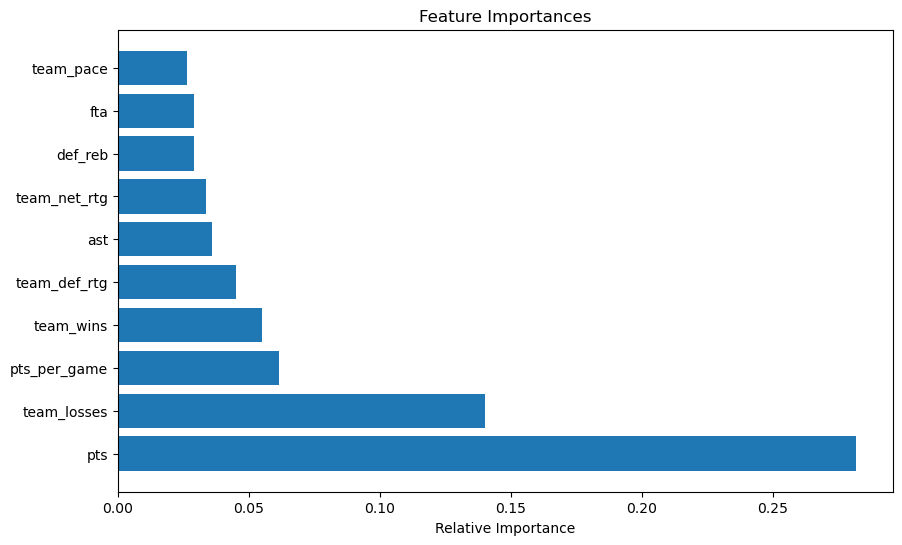

In [14]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(10), importances[indices], align="center")
plt.yticks(range(10), X.columns[indices])
plt.xlabel("Relative Importance")
plt.show()

#### MVP Conclusions

Points are the most important feature associated with MVP voting points. This makes sense as players who score the most are the most likely to have the highest positive impact for their team. Notably, the next two most important features are team losses and team wins. If you are the best player on a losing team, you are unlikely to be chosen for an MVP awards as MVPs are commonly seen as the player on a taem who can turn a game in their team's favor.

### DPOY

C:\Users\Evan\AppData\Local\Temp\ipykernel_25852\2515596634.py:14: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



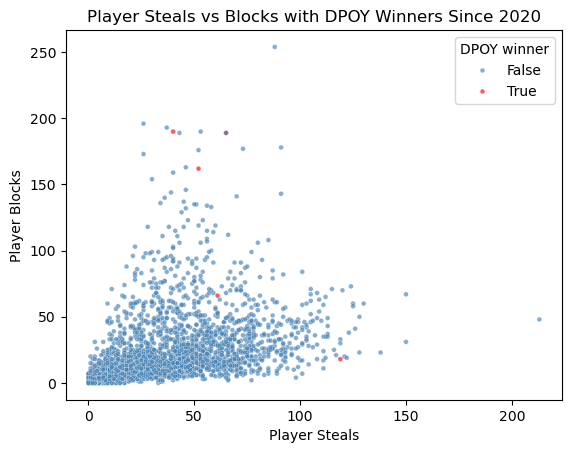

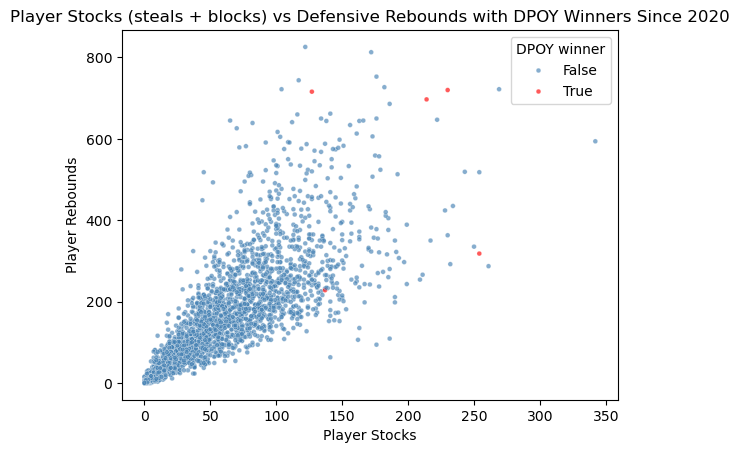

In [15]:
# EDA 


# - data cleaning

nba['stocks'] = nba['stl'] + nba['blk']

dpoy = (
    nba
    .merge(dpoy_players, on = ['player', 'season'], how = 'left')
)

dpoy['dpoy_voting_pts'] = dpoy['dpoy_voting_pts'].fillna(0)
dpoy['won_dpoy'] = dpoy['won_dpoy'].fillna(False)
dpoy2 = dpoy[dpoy['season'] >= 2020]


# - steals vs blocks with won_dpoy as color code

sns.scatterplot(data=dpoy2, x='stl', y='blk', hue='won_dpoy', palette={False: "steelblue", True: "red"}, s=12, alpha=0.65)
plt.xlabel("Player Steals")
plt.ylabel("Player Blocks")
plt.title("Player Steals vs Blocks with DPOY Winners Since 2020")
plt.legend(title="DPOY winner")
plt.show()

# - stocks vs def_reb with won_dpoy as color code

sns.scatterplot(data=dpoy2, x='stocks', y='def_reb', hue='won_dpoy', palette={False: "steelblue", True: "red"},  
s=12, alpha=0.65)
plt.xlabel("Player Stocks")
plt.ylabel("Player Rebounds")
plt.title("Player Stocks (steals + blocks) vs Defensive Rebounds with DPOY Winners Since 2020")
plt.legend(title="DPOY winner")
plt.show()


In the first graph, displaying steals vs blocks, we see that most players either have high block counts or high steal counts. This is because taller players are better at blocking and and shorter players are better at stealing. The DPOY winners are the players who have the most blocks, steals, or somewhere in the middle with high counts in both columns.

The second graph illustrates a new statistic - stocks - which we summed each player's steals and blocks counts in a new column. This stat is compared to defensive rebounds, which is another important defensive stat. First, we can observe the trend that players with higher stock counts typically also have higher rebound counts. This then yields better defensive players which are typically our DPOY winners.

In [16]:
dpoy = dpoy[dpoy['games_started']>50]
dpoy_mod = dpoy[['player', 'season','stl', 'blk','team_def_rtg' , 'def_reb', 'won_dpoy']]
dpoy_mod = dpoy_mod.dropna()

dpoy_X = dpoy_mod[['stl', 'blk','team_def_rtg' , 'def_reb']]
dpoy_result = dpoy_mod['won_dpoy']

X_train, X_test, y_train, y_test = train_test_split(dpoy_X, dpoy_result, test_size = 0.2)
X_train

logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

total_cases = len(y_pred)
negative_cases = len(y_pred[y_pred == 0])  

print("losers: ", negative_cases)
print("total: ",total_cases)



Accuracy: 0.8713080168776371
losers:  818
total:  948


In [17]:
dpoy_mod.head()

,player,season,stl,blk,team_def_rtg,def_reb,won_dpoy
37,Caldwell Jones,1980,43.0,162.0,101.0,731.0,False
41,Cedric Maxwell,1980,76.0,61.0,101.9,420.0,False
45,Chris Ford,1980,111.0,27.0,101.9,104.0,False
55,Darryl Dawkins,1980,49.0,142.0,101.0,496.0,False
57,Dave Cowens,1980,69.0,61.0,101.9,408.0,False


In [18]:
dpoy25 = dpoy_mod[dpoy_mod['season']==2025]
dpoy25_predictions = logreg.predict(dpoy25.drop(columns=dpoy_mod[['player','season', 'won_dpoy']]))
dpoy25_probabilities = logreg.predict_proba(dpoy25.drop(columns=dpoy_mod[['player','season', 'won_dpoy']]))

dpoy25_win_odds = dpoy25_probabilities[:, 1]

dpoy25_results = pd.DataFrame({'player': dpoy25.player,
                               'pred_prob':dpoy25_win_odds}).sort_values(by='pred_prob', ascending=False)
dpoy25_results.head(15)

,player,pred_prob
17900,Shai Gilgeous-Alexander,0.317393
17654,Ivica Zubac,0.173426
17681,Jalen Williams,0.157464
17493,Alperen Şengün,0.125504
17614,Dyson Daniels,0.120752
17687,James Harden,0.103629
17621,Evan Mobley,0.092617
17665,Jaden McDaniels,0.091388
17695,Jarrett Allen,0.089794
17886,Rudy Gobert,0.089504


We used logistic regression for our defensive player of the year prediciton. The main issue we ran into was the model only predicting losers. To fix this, we only included data for players with over 50 games played, and also used 'balanced' for the class_weight parameter. This parameter adjusts the weight of the classes to be inveresly proportional to their frequencies. There are very few winners compared to candidates.

We gave the model 'player', 'season','steals', 'blocks','team defensive rating' , 'defensive rebounds', 'won dpoy'. The accuracy hovers around 0.89. The top 15 candidates with the most share of prediction probability are all mostly great defensive players and there only a few weird names in there.

### ROTY

Rookie of the Year (ROTY) is an annual NBA award given to the top rookie of the season, in other words the player who had the best debut season. ROTY is selected by a panel of American and Canadian journalists who rank their top 3 candidates for the award. Five points is awarded for first place, three points for second, and one point for third. The player with the highest sum of voting points wins the award.

Here are the five most recent ROTY winners:

In [19]:
roty[roty['won_roty'] == True].sort_values(by = 'season', ascending = False).head()

,seas_id,player,season,team_x,team_abbr,position,age,experience,avg_dist_fga,fg_percent_2p,...,team_wins,team_losses,team_off_rtg,team_def_rtg,team_net_rtg,team_pace,team_y,roty_voting_pts,roty_share,won_roty
1597,31850.0,Victor Wembanyama,2024,San Antonio Spurs,SAS,C,20.0,1,13.0,0.534,...,22.0,60.0,110.0,116.4,-6.4,101.1,SAS,495.0,1.000,True
1560,30982.0,Paolo Banchero,2023,Orlando Magic,ORL,PF,20.0,1,12.4,0.471,...,34.0,48.0,111.6,114.2,-2.6,99.3,ORL,494.0,0.988,True
1532,30324.0,Scottie Barnes,2022,Toronto Raptors,TOR,PF,20.0,1,10.9,0.543,...,48.0,34.0,112.9,110.5,2.4,96.0,TOR,378.0,0.756,True
1482,29365.0,LaMelo Ball,2021,Charlotte Hornets,CHO,PG,19.0,1,13.7,0.489,...,33.0,39.0,110.9,112.8,-1.9,98.3,CHO,465.0,0.939,True
1445,28537.0,Ja Morant,2020,Memphis Grizzlies,MEM,PG,20.0,1,9.5,0.511,...,34.0,39.0,109.2,110.3,-1.1,102.8,MEM,498.0,0.996,True


We are interested in creating models that can predict ROTY for 2025. For models, we will compare the performances of a Random Forest and XGBoost model. We will train the models on candidates before the 2025 season and for predictors we will some essential basketball statistics that are indicative of a plyer's quality: Field Goal Percentage (FG%), Basic Per Game Stats (Points per game, Assists per game, etc.), Team Wins, and whether the team made playoffs that season.

For the response variable, we want to predict a player's share in the vote.

We will use an 80/20 train-test split for our data in the cross validation process.

Note: Earlier, we filtered the NBA dataset to not only include players who have strictly one year of experience in the league (thus, they are a rookie), but also to have played a minimum of 40 games in the season. Early model creation predicted players with very little game time winning the award, which we know to be unrealistic because historically ROTY winners have player more than 40 games. For the sake of model accuracy, we are adding this condition. 
(We know this rules out Jared McCain...sorry)

In [20]:
# Separate 2025 candidates from rest of data
roty_25 = roty.query("season == 2025")
roty_mod = roty.query("season != 2025")

# Get X and Y
roty_X = roty_mod[['mp_per_game', 'fg_percent', 'trb_per_game', 'ast_per_game', 'stl_per_game', 
               'blk_per_game', 'pts_per_game', 'team_wins', 'team_made_playoffs']]
roty_Y = roty_mod[['roty_share']]

# Create train/test split
roty_X_train, roty_X_test, roty_y_train, roty_y_test = train_test_split(
    roty_X,
    roty_Y,
    test_size = 0.2,
    random_state=3870
)

roty_X_train.head()

,mp_per_game,fg_percent,trb_per_game,ast_per_game,stl_per_game,blk_per_game,pts_per_game,team_wins,team_made_playoffs
418,22.6,0.519,2.9,1.6,1.3,0.1,12.1,37.0,False
1464,16.8,0.456,3.3,1.6,0.5,0.2,7.5,53.0,True
1580,21.1,0.425,2.2,1.1,0.6,0.0,8.5,25.0,False
214,24.7,0.511,5.7,0.5,0.5,1.1,10.6,36.0,True
551,16.7,0.484,2.7,0.8,1.0,0.3,5.0,53.0,True


While training the Random Forest, we will apply a grid search to optimize the number of trees, features allowed per tree, and maximum depth per tree. We will use 5-Fold CV with R-squared scoring to ensure accurate error measurements and ensure we select the best model.

In [21]:
# Tune random forest
# Hyper grid has 7x9x7 possible combinations
roty_rf_hg = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_features': np.arange(1, 10, 1).tolist(),
    'max_depth': [1, 2, 5, 10, 25, 50, None]
}

roty_rf_grid_search = GridSearchCV(
    estimator = ensemble.RandomForestRegressor(random_state = 3870),
    param_grid = roty_rf_hg,
    cv = KFold(n_splits = 5, shuffle = True, random_state = 3870),
    scoring = 'r2',
    n_jobs = -1
)

roty_rf_grid_search.fit(X = roty_X_train, y = roty_y_train)

roty_rf_grid_search.best_estimator_

c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(max_depth=10, max_features=2, n_estimators=300,
                      random_state=3870)

With the best Random Forest model obtained, we will now test it against the validation set.

In [22]:
# Test tuned random forest
roty_best_rf = roty_rf_grid_search.best_estimator_
print(f"Tuned Random Forest R^2: {roty_best_rf.score(roty_X_test, roty_y_test)}")


Tuned Random Forest R^2: 0.5680879787489417


The Random Forest performs fairly well in predicting ROTY. Now, let's see how important each predictor is in the model.

In [23]:
roty_feature_imp = pd.DataFrame(
    {
        "Feature": roty_best_rf.feature_names_in_,
        "Importance": roty_best_rf.feature_importances_
    }
).sort_values('Importance', ascending = False)

roty_feature_imp.reset_index(drop = True)

,Feature,Importance
0,pts_per_game,0.272206
1,mp_per_game,0.198658
2,trb_per_game,0.144964
3,ast_per_game,0.110663
4,blk_per_game,0.074646
5,stl_per_game,0.063538
6,fg_percent,0.062116
7,team_wins,0.060910
8,team_made_playoffs,0.012299


The three most important predictors in the model were points per game, minutes played per game, and total rebounds per game. Points per game is the best, which make sense as points are the most valuable statistic in basketball. On the other hand, team wins and whether the team made playoffs were the least important predictors, which also makes sense since ROTY focuses on the individual's quality rather than the team.

<Axes: xlabel='Feature'>

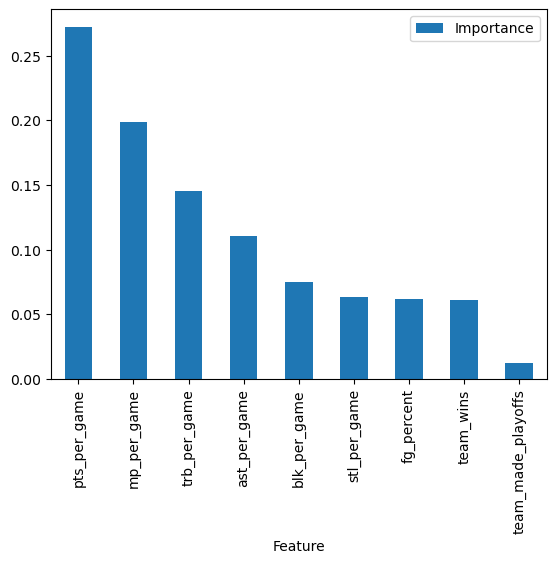

In [24]:
roty_feature_imp.set_index('Feature').plot(kind = 'bar')

Now, we will use the Random Forest model to predict the ROTY for 2025.

In [25]:
# Make predictions for 2025
roty_pred_rf = roty_best_rf.predict(roty_25[['mp_per_game', 'fg_percent', 'trb_per_game', 'ast_per_game', 'stl_per_game', 
               'blk_per_game', 'pts_per_game', 'team_wins', 'team_made_playoffs']])

roty_results_rf = pd.DataFrame({
    'Player': roty_25.player,
    'Predicted Share': roty_pred_rf
}).sort_values(by = 'Predicted Share', ascending = False)

roty_results_rf.head(10)


,Player,Predicted Share
1599,Alex Sarr,0.101195
1605,Isaiah Collier,0.037988
1624,Stephon Castle,0.027967
1609,Jaylen Wells,0.026748
1600,Bub Carrington,0.020385
1627,Yves Missi,0.019993
1613,Justin Edwards,0.019764
1628,Zaccharie Risacher,0.016499
1604,Donovan Clingan,0.013124
1629,Zach Edey,0.012495


The Random Forest predicts Alex Sarr to win with 10.1% of the voting points, considerably ahead of Isiah Collier with an expected 3.8% share. 

Next, we will create an XGBoost model to predict ROTY voting share. For the hyper parameter grid, we will test values for the learning rate, number of trees, maximum tree depth, number of features allowed per tree, and the regularization parameter to determine the optimal XGBoost model. We use 5-Fold CV again and set the XGBRegressor to 50 early_stopping_rounds, meaning it will terminate early if there is no significant improvement in model fit after 50 trees. Lastly, since there are a large number of combinations of hyper parameters in the gird, we will apply a randomized search to randomly select 1000 of these combinations for runtime purposes.

In [26]:
# Tune XGBoost model
# Hyper grid has 7350 possible combinations... use 1000
roty_xgb_hg = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [10, 50, 100, 250, 500, 750, 1000], 
    'max_depth': [1, 2, 5, 10, 25, 50],                 
    'colsample_bytree': [0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.0],
    'lambda': [0, 0.5, 1, 2, 5]            
}

roty_xgb_grid_search = RandomizedSearchCV(
    estimator = XGBRegressor(random_state = 3870, early_stopping_rounds = 50),
    param_distributions = roty_xgb_hg,
    n_iter = 1000,
    cv = KFold(n_splits = 5, shuffle = True, random_state = 3870),
    n_jobs = -1
)

roty_best_xgb = (roty_xgb_grid_search
                 .fit(X = roty_X_train, y = roty_y_train, eval_set = [(roty_X_test, roty_y_test)], verbose = False)
                 .best_estimator_)

roty_best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.67, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, ...)

Now that we have our best XGBRegressor, we will test it on the testing set.

In [27]:
# Test tuned XGBoost Regressor model
print(f"Tuned XGBoost Regressor R^2: {roty_best_xgb.score(roty_X_test, roty_y_test)}")

Tuned XGBoost Regressor R^2: 0.6231310367584229


The XGBoost model also performs well in predicting ROTY, in fact slightly better than the Random Forest.

Below, we use the XGBoost model to predict the ROTY voting share for 2025.

In [28]:
# Make predictions for 2025
roty_pred_xgb = roty_best_xgb.predict(roty_25[['mp_per_game', 'fg_percent', 'trb_per_game', 'ast_per_game', 'stl_per_game', 
               'blk_per_game', 'pts_per_game', 'team_wins', 'team_made_playoffs']])

roty_results_xgb = pd.DataFrame({
    'Player': roty_25.player,
    'Predicted Share': roty_pred_xgb
}).sort_values(by = 'Predicted Share', ascending = False)

roty_results_xgb

,Player,Predicted Share
1599,Alex Sarr,0.082408
1600,Bub Carrington,0.049626
1609,Jaylen Wells,0.048070
1624,Stephon Castle,0.046041
1628,Zaccharie Risacher,0.022199
1627,Yves Missi,0.016966
1607,Jamal Shead,0.014988
1613,Justin Edwards,0.013622
1604,Donovan Clingan,0.010806
1629,Zach Edey,0.009804


The XGBoost model also predicts Alex Sarr to win ROTY with a 5.7% share, followed closely by Jaylen Wells and Stephon Castle with 4.9% and 4.8% respectively.

#### ROTY Conclusions

The Random Forest and XGBoost models both performed moderately well in predicting ROTY voting share with R-squared values of approximately 0.6. Both models agreed Alex Sarr will get the greatest proportion of votes, which is understandable as he is considered one of the top candidates for this year's award. However most betting sites favor Stephon Castle, which our models predict him to place third in the running.

Points per game is a strong predictor for ROTY share, as a rookie who consistently contributes many points to their team is indicative of a player's success in their debut season. Minutes per game is also a strong predictor as it implies the rookie is immediately becoming a crucial part to the organization, a testament to their quality.

For future improvements to these models, it will be worth adding more advanced statistics such as box plus/minus and win shares to gauge their impact on a ROTY candidate's share in the voting. 

### All-NBA

The All-NBA Team is an annual honor awarded by the National Basketball Association (NBA) to the league's top players for their performance during the regular season. Voted on by a panel of sportswriters and broadcasters, the award is divided into three teams—First, Second, and Third— each consisting of two gaurds, two forwards, and one center. Being named to an All-NBA Team is a prestigious recognition that reflects a player's excellence and consistency throughout the year.

In this section, we will try to predict players selected for the All-NBA team. The model will be trained on NBA player season data from 1980 to the present excluding the 2025 NBA Season. We are trying to predict the column called 'any_all_nba' that has a 0 if a player was not on an All-NBA team and 1 indicating that a player was on an All-NBA team.

Since All-NBA is broken down by position, we will create a seperate model for gaurds, forwards, and centers. Once the random forest is made, we will use variable importance to see if different stats have more impact on predicting All-NBA status based on a players position.

In [29]:
# data prepping

all_nba = nba.merge(all_nba_players, on = ['player', 'season'], how = 'left')
#all_nba.head()
all_nba['all_nba_voting_pts'] = all_nba['all_nba_voting_pts'].fillna(0)
all_nba['all_nba_team'] = all_nba['all_nba_team'].fillna('No Votes')
all_nba['all_nba_team'] = all_nba['all_nba_team'].replace({
    '1T': '1st', 
    '2T': '2nd', 
    '3T': '3rd', 
    'ORV': 'Others Receiving Votes'
})

# assigning an order to the All-NBA teams so graphs look nice
ordered_categories = ['1st', '2nd', '3rd', 'Others Receiving Votes', 'No Votes']
all_nba['all_nba_team'] = pd.Categorical(all_nba['all_nba_team'], categories=ordered_categories, ordered=True)
all_nba.head()

# making pos2 column for position
all_nba['pos2'] = all_nba['position'].apply(lambda x: 'Guard' if x in ['PG', 'SG'] 
                                        else ('Forward' if x in ['SF', 'PF'] 
                                              else ('Center' if x == 'C' else 'Unknown')))

# showing the 2024 All-NBA 1st Team
all_nba.query("season == 2024 and all_nba_team == '1st'")

,seas_id,player,season,team,team_abbr,position,age,experience,avg_dist_fga,fg_percent_2p,...,team_wins,team_losses,team_off_rtg,team_def_rtg,team_net_rtg,team_pace,stocks,all_nba_team,all_nba_voting_pts,pos2
17144,31366.0,Giannis Antetokounmpo,2024,Milwaukee Bucks,MIL,PF,29.0,11,6.7,0.645,...,49.0,33.0,118.4,115.8,2.6,99.9,166.0,1st,473.0,Forward
17219,31468.0,Jayson Tatum,2024,Boston Celtics,BOS,PF,25.0,7,15.4,0.542,...,64.0,18.0,123.2,111.6,11.6,97.2,118.0,1st,427.0,Forward
17316,31593.0,Luka Dončić,2024,Dallas Mavericks,DAL,PG,24.0,6,16.9,0.573,...,50.0,32.0,117.6,115.4,2.2,100.1,137.0,1st,493.0,Guard
17369,31672.0,Nikola Jokić,2024,Denver Nuggets,DEN,C,28.0,9,9.7,0.626,...,57.0,25.0,118.5,113.0,5.5,96.8,176.0,1st,495.0,Center
17421,31769.0,Shai Gilgeous-Alexander,2024,Oklahoma City Thunder,OKC,PG,25.0,6,11.3,0.576,...,57.0,25.0,119.5,112.1,7.4,99.8,217.0,1st,495.0,Guard


The 2024 All-NBA first team is shown above.

#### All-NBA Specific EDA

C:\Users\Evan\AppData\Local\Temp\ipykernel_25852\2502867379.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



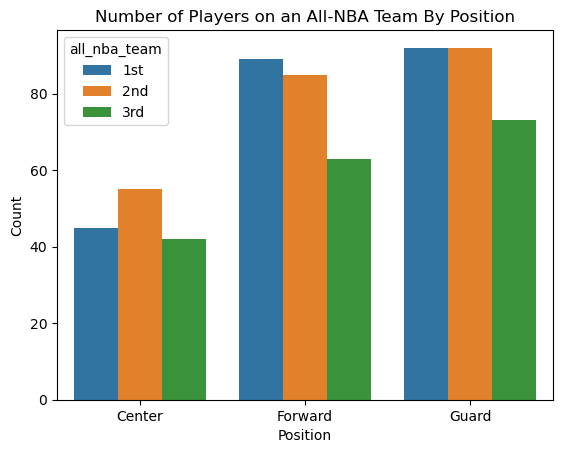

In [30]:
# make a bar chart showing the distribution by position - grouped into gaurds, forwards, centers
pos2_counts = (all_nba
               .query("all_nba_team != 'No Votes' and all_nba_team != 'Others Receiving Votes'")
               .groupby(['all_nba_team', 'pos2'])
               .size()
               .reset_index(name='count')
              )

# assigning an order to the All-NBA teams so graphs look nice
ordered_categories2 = ['1st', '2nd', '3rd']
pos2_counts['all_nba_team'] = pd.Categorical(pos2_counts['all_nba_team'], categories=ordered_categories2, ordered=True)

# graphing team count by position
sns.barplot(data=pos2_counts, x='pos2', y='count', hue='all_nba_team')
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Number of Players on an All-NBA Team By Position')
plt.show();
#pos2_counts.all_nba_team.unique

In [31]:
all_nba2 = all_nba.query('season >= 2020')
all_nba2.head(10)

,seas_id,player,season,team,team_abbr,position,age,experience,avg_dist_fga,fg_percent_2p,...,team_wins,team_losses,team_off_rtg,team_def_rtg,team_net_rtg,team_pace,stocks,all_nba_team,all_nba_voting_pts,pos2
15071,28290.0,Aaron Gordon,2020,Orlando Magic,ORL,PF,24.0,6,12.9,0.494,...,33.0,40.0,108.5,109.5,-1.0,98.6,90.0,No Votes,0.0,Forward
15072,28291.0,Aaron Holiday,2020,Indiana Pacers,IND,PG,23.0,2,15.1,0.427,...,45.0,28.0,110.0,108.0,2.0,98.9,71.0,No Votes,0.0,Guard
15073,28292.0,Abdel Nader,2020,Oklahoma City Thunder,OKC,SF,26.0,3,14.8,0.556,...,44.0,28.0,110.8,108.8,2.0,98.8,43.0,No Votes,0.0,Forward
15074,28293.0,Adam Mokoka,2020,Chicago Bulls,CHI,SF,21.0,1,14.2,0.462,...,22.0,43.0,106.7,109.8,-3.1,99.7,4.0,No Votes,0.0,Forward
15075,28294.0,Admiral Schofield,2020,Washington Wizards,WAS,PF,22.0,1,18.6,0.516,...,25.0,47.0,110.9,115.5,-4.6,102.7,12.0,No Votes,0.0,Forward
15076,28295.0,Al Horford,2020,Philadelphia 76ers,PHI,C,33.0,13,15.4,0.516,...,43.0,30.0,111.3,109.0,2.3,99.0,113.0,No Votes,0.0,Center
15077,28296.0,Al-Farouq Aminu,2020,Orlando Magic,ORL,PF,29.0,10,13.3,0.320,...,33.0,40.0,108.5,109.5,-1.0,98.6,26.0,No Votes,0.0,Forward
15078,28300.0,Alen Smailagić,2020,Golden State Warriors,GSW,C,19.0,1,11.4,0.630,...,15.0,50.0,105.2,113.8,-8.6,100.3,7.0,No Votes,0.0,Center
15079,28301.0,Alex Caruso,2020,Los Angeles Lakers,LAL,PG,25.0,3,13.7,0.468,...,52.0,19.0,112.0,106.3,5.7,100.9,88.0,No Votes,0.0,Guard
15080,28305.0,Alfonzo McKinnie,2020,Cleveland Cavaliers,CLE,SF,27.0,3,12.2,0.557,...,19.0,46.0,107.5,115.4,-7.9,98.7,31.0,No Votes,0.0,Forward


Unlike the previous awards, the All-NBA awards are given out on a by position basis. Every year, two gaurds, two forwards, and one center is elected to each All-NBA team. The small fluctuations by position and team come from players that play more than one position. For example, Michael Jordan played both Shooting Gaurd and Small Forward and must be categorized as a gaurd or a forward.

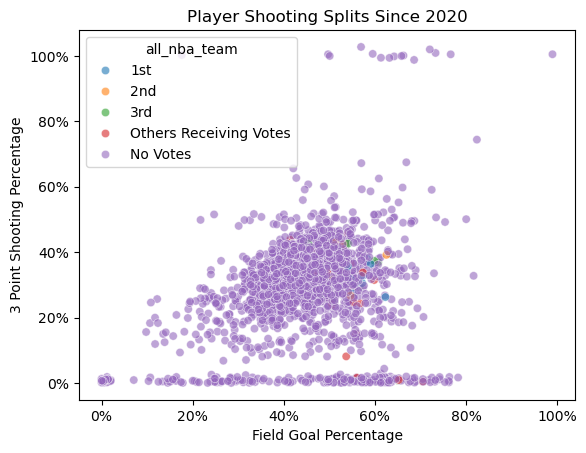

In [32]:
# make a scatterplot with shooting percentage and 3p shooting percentage with dots colored by all_nba_team

x_jittered = abs(all_nba2['fg_percent'] + np.random.normal(0, 0.01, size=len(all_nba2)))
y_jittered = abs(all_nba2['fg_percent_3p'] + np.random.normal(0, 0.01, size=len(all_nba2)))
sns.scatterplot(x = x_jittered, 
                y = y_jittered, 
                hue = all_nba2['all_nba_team'], 
                alpha = .6) 
#   !! add a jitter !!
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))  # scale 0–1 to 0–100%
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Field Goal Percentage')
plt.ylabel('3 Point Shooting Percentage')
plt.title('Player Shooting Splits Since 2020')
plt.show();

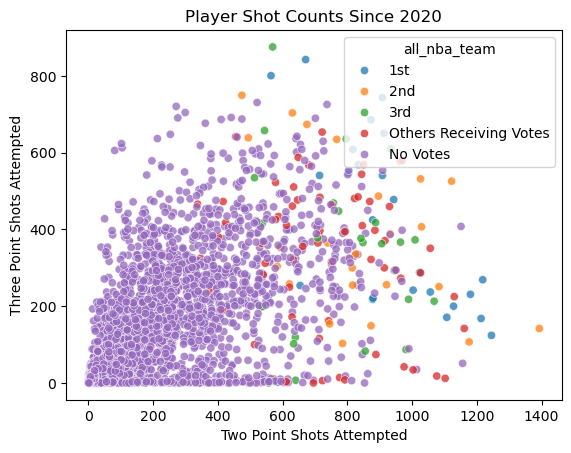

In [33]:
sns.scatterplot(data = all_nba2, x = 'x2pa', y = 'x3pa', hue = 'all_nba_team', alpha = .75)
plt.xlabel('Two Point Shots Attempted')
plt.ylabel('Three Point Shots Attempted')
plt.title('Player Shot Counts Since 2020')
plt.show();

The two graphs above reveal a common misconception in basketball: fans often assume that players on the top all-NBA teams boast the best shooting splits (FG% and 3PT%). However, this is not always the case. Due to their higher usage rates and increased shot attempts, these players' shooting percentages frequently align closer to the league average rather than being exceptional.

We’ll incorportate this insight in our model by prioritizing cumulative or total statistics instead of per-game averages. This approach provides a more accurate measure of player performance, especially when considering the larger roles these players take on within their teams. By doing so, we can hopefully make more informed predictions about which players truly belong on the top all-NBA teams.

After carefully examining the plots above and other basic variable relations, we decided to include the following variables in our random forest models predicting NBA: 
    experience (seasons played in the NBA),
    fga (field goals attempted),
    x3pa (3 point shots attempted),
    fta (free throws attempted),
    e_fg_percent (Effective Field Goal Percentage),
    tot_reb (total rebounds), 
    ast (assists), 
    stl (steals), 
    blk (blocks), 
    tov (turnovers), 
    pts (pts),
    team_wins (team_wins).

In [34]:
# make a decision tree by position predicting ANY team vs NO team - random forest
# use variable importance to extract what is the most meaningful stats for each preiction
# set aside 2025 data
all_nba['any_all_nba'] = all_nba['all_nba_team'].isin(['1st', '2nd', '3rd']) * 1

# Every All-NBA player has played at least 40 games
all_nba_mod = all_nba[all_nba['games_played'] > 40]
all_nba_mod = all_nba_mod[['player','season','any_all_nba', 'pos2','experience','fga','x3pa',
                    'fta','e_fg_percent','tot_reb', 'ast', 'stl', 
                    'blk', 'tov', 'pts','team_wins']]


all_nba_25 = all_nba_mod.query('season == 2025')
all_nba_mod = all_nba_mod.query('season != 2025')

# split up all nba by gaurds
all_nba_25_g = all_nba_25.query('pos2 == "Guard"')
all_nba_g = all_nba_mod.query('pos2 == "Guard"')

# make GAURD train/test
all_nba_g_X_train, all_nba_g_X_test, all_nba_g_y_train, all_nba_g_y_test = train_test_split(
    all_nba_g.drop(columns = ['player','season','any_all_nba', 'pos2'], axis = 1), 
    all_nba_g.any_all_nba, 
    test_size = 0.2, 
    random_state = 3870)

# split up all nba by forwards
all_nba_25_f = all_nba_25.query('pos2 == "Forward"')
all_nba_f = all_nba_mod.query('pos2 == "Forward"')

# make FORWARD train/test
all_nba_f_X_train, all_nba_f_X_test, all_nba_f_y_train, all_nba_f_y_test = train_test_split(
    all_nba_f.drop(columns = ['player','season','any_all_nba', 'pos2'], axis = 1), 
    all_nba_f.any_all_nba, 
    test_size = 0.2, 
    random_state = 3870)

# split up all nba by centers
all_nba_25_c = all_nba_25.query('pos2 == "Center"')
all_nba_c = all_nba_mod.query('pos2 == "Center"')

# make CENTER train/test
all_nba_c_X_train, all_nba_c_X_test, all_nba_c_y_train, all_nba_c_y_test = train_test_split(
    all_nba_c.drop(columns = ['player','season','any_all_nba', 'pos2'], axis = 1), 
    all_nba_c.any_all_nba, 
    test_size = 0.2, 
    random_state = 3870)


#### Prepping for Random Forests
Below, we set up a for cross validation and a grid search for hyper-parameters in our random forest. We also split up the data by position and also into the training (70%) and testing sets (30%). 

In [35]:
from sklearn.model_selection import KFold, RandomizedSearchCV
# set up 5-fold CV for each position df
cv5 = KFold(n_splits=5, shuffle=True, random_state=3870)

# set up grid for grid search
hyper_grid = {
    'n_estimators': [200, 300, 400, 500, 750],
    'max_features': np.arange(2, 9, 1).tolist(),
    'max_depth': [2, 10, 20, 50]
}

hyper_grid

{'n_estimators': [200, 300, 400, 500, 750],
 'max_features': [2, 3, 4, 5, 6, 7, 8],
 'max_depth': [2, 10, 20, 50]}

In [36]:
# RANDOM grid search for all three positions

# Forming the empty trees for each combo of parameters in hyper_grid
hp_rand_search_g = RandomizedSearchCV(
    ensemble.RandomForestRegressor(random_state = 3870),
    param_distributions = hyper_grid,
    n_iter = 100,
    cv = cv5,
    random_state = 3870,
    n_jobs = -1
)

hp_rand_search_f = RandomizedSearchCV(
    ensemble.RandomForestRegressor(random_state = 3870),
    param_distributions = hyper_grid,
    n_iter = 100,
    cv = cv5,
    random_state = 3870,
    n_jobs = -1
)

hp_rand_search_c = RandomizedSearchCV(
    ensemble.RandomForestRegressor(random_state = 3870),
    param_distributions = hyper_grid,
    n_iter = 100,
    cv = cv5,
    random_state = 3870,
    n_jobs = -1
)

#### Finding Best Model By Position

The RandomizedSearchCV function in the previous code chunk is Randomly searching over the hyperparameter grid set up two code chunks prior.
It randomly selects new combinations from the hypergrid and forms an empty tree. 
Then, in the code chunks below, we fit the Random Forest using cross validation on the testing set of data for each position.
The fit function will return the best hyper parameter selection for the random forest. The best parameters for each model are printed after it is fit.

In [37]:
hp_rand_search_g.fit(X = all_nba_g_X_train, y = all_nba_g_y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=3870, shuffle=True),
                   estimator=RandomForestRegressor(random_state=3870),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 10, 20, 50],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8],
                                        'n_estimators': [200, 300, 400, 500,
                                                         750]},
                   random_state=3870)

In [38]:
print(f'The best parameters from the random search for gaurds are: {hp_rand_search_g.best_params_}')
print(f'The best R2 from the random search for gaurds is: {hp_rand_search_g.best_score_: .3f}')

The best parameters from the random search for gaurds are: {'n_estimators': 300, 'max_features': 7, 'max_depth': 50}
The best R2 from the random search for gaurds is:  0.541


In [39]:
hp_rand_search_f.fit(X = all_nba_f_X_train, y = all_nba_f_y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=3870, shuffle=True),
                   estimator=RandomForestRegressor(random_state=3870),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 10, 20, 50],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8],
                                        'n_estimators': [200, 300, 400, 500,
                                                         750]},
                   random_state=3870)

In [40]:
print(f'The best parameters from the random search for forwards are: {hp_rand_search_f.best_params_}')
print(f'The best R2 from the random search for forwards is: {hp_rand_search_f.best_score_: .3f}')

The best parameters from the random search for forwards are: {'n_estimators': 300, 'max_features': 6, 'max_depth': 10}
The best R2 from the random search for forwards is:  0.641


In [41]:
hp_rand_search_c.fit(X = all_nba_c_X_train, y = all_nba_c_y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=3870, shuffle=True),
                   estimator=RandomForestRegressor(random_state=3870),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 10, 20, 50],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8],
                                        'n_estimators': [200, 300, 400, 500,
                                                         750]},
                   random_state=3870)

In [42]:
print(f'The best parameters from the random search for centers are: {hp_rand_search_c.best_params_}')
print(f'The best R2 from the random search for centers is: {hp_rand_search_c.best_score_: .3f}')

The best parameters from the random search for centers are: {'n_estimators': 500, 'max_features': 6, 'max_depth': 20}
The best R2 from the random search for centers is:  0.567


#### Evaluating the Model Results

In the code chunks below, the final version of each tree is made. Variable importance of each model is then interpreted.

In [43]:
# making the best model for each position so we can extract variable importance
# for GAURDS
all_nba_rf_g = ensemble.RandomForestRegressor(
    n_estimators = 300,
    max_depth = 50, 
    bootstrap = True, 
    max_features = 7,   
    n_jobs = -1,         
    random_state = 3870
).fit(
    X = all_nba_g_X_train, 
    y = all_nba_g_y_train
)

# for FORWARDS
all_nba_rf_f = ensemble.RandomForestRegressor(
    n_estimators = 750,
    max_depth = 50,  
    bootstrap = True,   
    max_features = 6,    
    n_jobs = -1,         # Uses all cores on your computer (speeds up processing)
    random_state = 3870
).fit(
    X = all_nba_f_X_train, 
    y = all_nba_f_y_train
)

# for CENTERS
all_nba_rf_c = ensemble.RandomForestRegressor(
    n_estimators = 200,  
    max_depth = 10,    
    bootstrap = True,  
    max_features = 2,   
    n_jobs = -1,         
    random_state = 3870
).fit(
    X = all_nba_c_X_train, 
    y = all_nba_c_y_train
)

<Axes: xlabel='feature'>

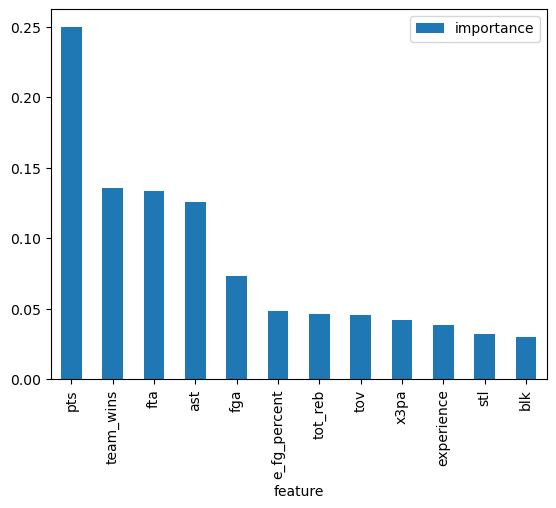

In [44]:
# Show variable importance for each position
feat_imp_g = pd.DataFrame({
    'feature': all_nba_g_X_train.columns,
    'importance': all_nba_rf_g.feature_importances_
}).sort_values(by = 'importance', ascending = False)
feat_imp_g.set_index('feature').plot(kind = 'bar')
#feat_imp_g

<Axes: xlabel='feature'>

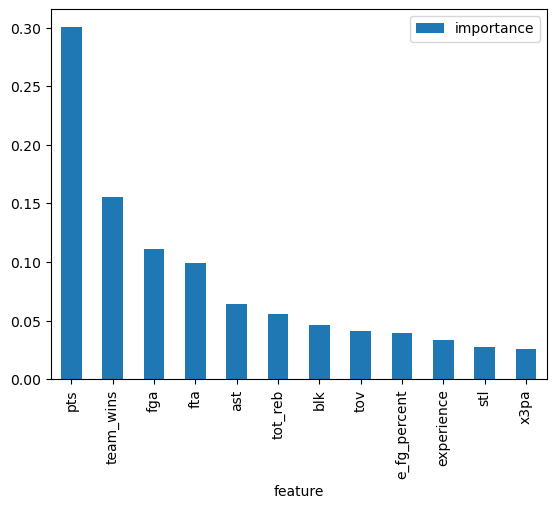

In [45]:
# Show variable importance for FORWARDS
feat_imp_f = pd.DataFrame({
    'feature': all_nba_f_X_train.columns,
    'importance': all_nba_rf_f.feature_importances_
}).sort_values(by = 'importance', ascending = False)

#feat_imp_f
feat_imp_f.set_index('feature').plot(kind = 'bar')

<Axes: xlabel='feature'>

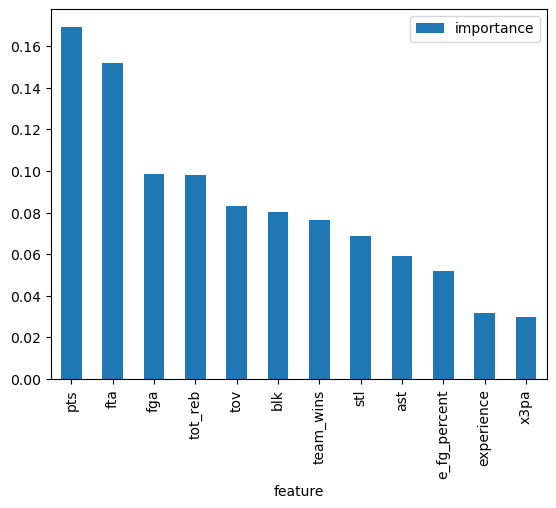

In [46]:
# Show variable importance for CENTERS
feat_imp_c = pd.DataFrame({
    'feature': all_nba_c_X_train.columns,
    'importance': all_nba_rf_c.feature_importances_
}).sort_values(by = 'importance', ascending = False)

feat_imp_c.set_index('feature').plot(kind = 'bar')
#feat_imp_c

#### Takeaways from Variable Importance

As expected, points was hte most important feature for all the trees. The best players in the NBA are the ones that can score consistently on all three levels.

Team Wins was the next most important feature for gaurds and forwards, however, it was not very important for centers. This is something that could be explored further in the future. If team wins are indicative to whether or not a gaurd or forward is on a All-NBA team, is the opposite true? In other words, do gaurds and forwards have more impact on team success than centers? Does this indicate that the best centers is less influence on their teams seasonal outcome?

Besides the discrepancy in team wins, the feature importance for the rest of the features is as expected. Free throws attempted, assists, and field goals attempted are the next most important for gaurds and forwards (with assists being more important for gaurds due to the fact that they handle the ball more). 

For centers, after points, free throws attempted and field goals attempted come after points demonstrating that scoring is the most important thing a center can do. After these predictors, rebounds and blocks - areas where centers dominate - play a large role in correctly predicting All-NBA status.
#### Predicting the 2025 All-NBA Teams

In [47]:
# Predict on 2025 Data for each position
cols_to_drop = ['any_all_nba', 'player', 'pos2', 'season']

# Predict for GUARDS
g25_predictions = all_nba_rf_g.predict(all_nba_25_g.drop(columns=cols_to_drop))

# Predict for FORWARDS
f25_predictions = all_nba_rf_f.predict(all_nba_25_f.drop(columns=cols_to_drop))

# Predict for CENTERS
c25_predictions = all_nba_rf_c.predict(all_nba_25_c.drop(columns=cols_to_drop))

In [48]:
g_results = pd.DataFrame({
    'player': all_nba_25_g.player,  # adjust this if player info is stored differently
    'prediction': g25_predictions
}).sort_values(by='prediction', ascending=False)

f_results = pd.DataFrame({
    'player': all_nba_25_f.player,
    'prediction': f25_predictions
}).sort_values(by='prediction', ascending=False)

c_results = pd.DataFrame({
    'player': all_nba_25_c.player,
    'prediction': c25_predictions
}).sort_values(by='prediction', ascending=False)


# getting top results- 15 players
all_nba25_g = g_results.head(6)
all_nba25_f = f_results.head(6)
all_nba25_c = c_results.head(3)


all_nba25_teams_g = pd.DataFrame({
    'player': all_nba25_g.player,
    'prediction': all_nba25_g.prediction,
    'team_prediction': ['1st','1st','2nd','2nd','3rd','3rd']
})

all_nba25_teams_f = pd.DataFrame({
    'player': all_nba25_f.player,
    'prediction': all_nba25_f.prediction,
    'team_prediction': ['1st','1st','2nd','2nd','3rd','3rd']
})

all_nba25_teams_c = pd.DataFrame({
    'player': all_nba25_c.player,
    'prediction': all_nba25_c.prediction,
    'team_prediction': ['1st','2nd','3rd']
})

In [49]:
all_nba25_teams_g

,player,prediction,team_prediction
17900,Shai Gilgeous-Alexander,0.970000,1st
17501,Anthony Edwards,0.620000,1st
17604,Donovan Mitchell,0.610000,2nd
17673,Jalen Brunson,0.570000,2nd
17687,James Harden,0.533333,3rd
17906,Stephen Curry,0.366667,3rd


In [50]:
all_nba25_teams_f

,player,prediction,team_prediction
17704,Jayson Tatum,0.862667,1st
17631,Giannis Antetokounmpo,0.701333,1st
17787,LeBron James,0.673333,2nd
17764,Kevin Durant,0.518667,2nd
17587,DeMar DeRozan,0.337333,3rd
17859,Pascal Siakam,0.266667,3rd


In [51]:
all_nba25_teams_c

,player,prediction,team_prediction
17839,Nikola Jokić,0.722000,1st
17749,Karl-Anthony Towns,0.365531,2nd
17693,Jaren Jackson Jr.,0.153687,3rd


#### All-NBA Conclusion

Overall, the models are solid. They output an R2 around 0.6.

More importantly, when the data is used to predict on the 2025 NBA season, the results are pretty accurate. There are some names that don't belong, such as James Harden and Demar Derozan being named to the All-NBA 3rd Team. All of these players have the potential to or will make an All-NBA team this year. 

The model also seems to have a good understanding of the important stats at each position which is reflected in the variable importance section.

## Limitations & Recommendations for Future Work

One major limitation of this project is the class imbalance inherent in award prediction tasks. The number of players who win prestigious honors like MVP, DPOY, or ROTY is extremely small compared to the total number of players in the dataset each season. This makes models generally skew towards predicting non-winners.

To help handle the class imbalance problem, players who played less than a certain number of games(50 for MVP and DPOY and 40 for ROTY). Additionally, we had to exclude any players who appeared on multiple teams within a single season. Removing these rows of data means removing a considerable portion of the dataset, including potentially high-performing players

Beyond the stat sheet, it's important to acknowledge the influence of journalism and media narratives on NBA awards. Awards are often shaped not just by performance but how a player's story is told—breakout years, comebacks, team success, and market visibility all influence the panel of judges. This leads directly into voter bias, whether it's narrative-driven voting or "voter fatigue" with repeated winners. These human elements are nearly impossible to quantify but heavily influence outcomes.